# How to use

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simaki/epymetheus/blob/master/examples/howto/howto.ipynb)

In [1]:
# !pip install pandas matplotlib seaborn
# !pip install epymetheus

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
seaborn.set_style('ticks')

In [3]:
import epymetheus
from epymetheus import Trade, TradeStrategy

epymetheus?

Let's construct your own strategy by subclassing `TradeStrategy`.

In [4]:
class SimpleTrendFollower(TradeStrategy):
    """
    A simple trend-following strategy.
    Buys stocks for a month with the highest percentile of one month returns.

    Parameters
    ----------
    - percentile : float
        The threshold to buy or sell.
        E.g. If 0.1, buy stocks with returns of highest 10%.
    """
    def __init__(self, percentile, bet_price, take, stop, hold=DateOffset(months=3)):
        self.percentile = percentile
        self.bet_price = bet_price
        self.take = take
        self.stop = stop
        self.hold = hold

    @staticmethod
    def sorted_assets(universe, open_date):
        """
        Return list of asset sorted according to one-month returns.
        Sort is ascending (poor-return first).

        Returns
        -------
        list
        """
        onemonth_returns = universe.prices.loc[open_date] \
            / universe.prices.loc[open_date - DateOffset(months=1)]
        return list(onemonth_returns.sort_values().index)

    def logic(self, universe):
        n_trade = int(universe.n_assets * self.percentile)
        date_range = pd.date_range(universe.bars[0], universe.bars[-1], freq='BM')

        for open_date in date_range[1:]:
            assets = self.sorted_assets(universe, open_date)
            for asset in assets[:n_trade]:
                lot = self.bet_price / universe.prices.at[open_date, asset]
                yield Trade(
                    asset=asset,
                    lot=lot,
                    open_bar=open_date,
                    shut_bar=open_date + self.hold,
                    take=self.take,
                    stop=self.stop,
                )

In [5]:
strategy = SimpleTrendFollower(
    percentile=0.2, bet_price=10000, take=10000, stop=-1000,
)

The strategy can be readily applied to any `Universe`.

In [6]:
from epymetheus.datasets import fetch_usstocks

universe = fetch_usstocks(n_assets=10)
universe.prices

/usr/local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,AAPL,MSFT,AMZN,BRK-A,JPM,JNJ,WMT,BAC,PG,XOM
2000-01-01,3.187337,37.453701,76.125000,56100,28.151169,27.276423,47.794632,12.398399,29.213911,22.168360
2000-01-02,3.187337,37.453701,76.125000,56100,28.151169,27.276423,47.794632,12.398399,29.213911,22.168360
2000-01-03,3.470226,37.393559,89.375000,54800,26.407299,26.965630,46.195686,11.966080,28.580635,21.549223
2000-01-04,3.177650,36.130390,81.937500,52000,25.901106,25.978415,44.467136,11.255836,28.030689,21.136469
2000-01-05,3.224152,36.511333,69.750000,53200,25.741232,26.252653,43.559650,11.379356,27.497412,22.288738
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,289.113831,158.527008,1869.800049,338920,136.830582,144.826492,119.063171,35.125870,125.345390,68.900826
2019-12-28,289.113831,158.527008,1869.800049,338920,136.830582,144.826492,119.063171,35.125870,125.345390,68.900826
2019-12-29,289.113831,158.527008,1869.800049,338920,136.830582,144.826492,119.063171,35.125870,125.345390,68.900826
2019-12-30,290.829773,157.160736,1846.890015,338750,136.329041,144.379349,118.874016,34.927143,123.734962,68.496635


In [7]:
strategy.run(universe)

Running ... 
Generating 478 trades ({trade.open_bar}) ... Done. (Runtime : 0.52 sec)
Executing 478 trades ... Done. (Runtime : 0.51 sec)
Done. (Runtime : 1.03 sec)


Now the result is stored as the attributes of `strategy`.

You can plot the wealth right away:

In [8]:
df_wealth = strategy.wealth.to_dataframe()
df_wealth[-5:]

,wealth
bars,
2019-12-27,145696.739197
2019-12-28,145696.739197
2019-12-29,145696.739197
2019-12-30,145259.157251
2019-12-31,145335.380886


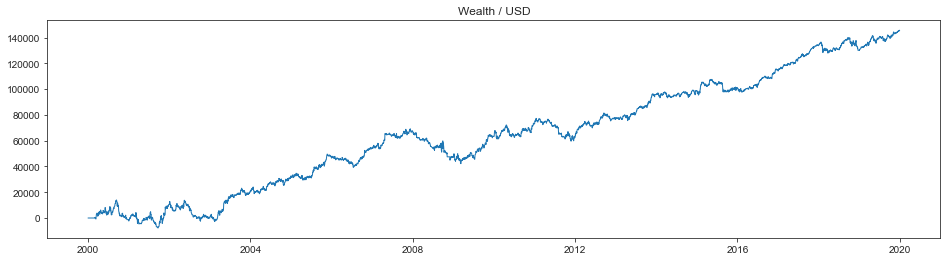

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(df_wealth, linewidth=1)
plt.title('Wealth / USD')
plt.show()

You can also inspect the exposure as:

In [10]:
# df_exposure = pd.Series(strategy.net_exposure, index=strategy.universe.bars)

# plt.figure(figsize=(16, 4))
# plt.plot(df_exposure)
# plt.axhline(0, ls='--', color='gray')
# plt.title('Net exposure')
# plt.show()

Profit-loss distribution can be accessed by:

In [11]:
df_history = strategy.history.to_dataframe()
df_history

,trade_id,asset,lot,open_bar,close_bar,shut_bar,take,stop,pnl
order_id,,,,,,,,,
0,0,BRK-A,0.227273,2000-02-29,2000-05-29,2000-05-29,10000,-1000,3045.454545
1,1,JNJ,471.410836,2000-02-29,2000-05-29,2000-05-29,10000,-1000,2328.741011
2,2,PG,657.238593,2000-03-31,2000-06-30,2000-06-30,10000,-1000,93.625737
3,3,AMZN,149.253731,2000-03-31,2000-04-12,2000-06-30,10000,-1000,-1585.820896
4,4,MSFT,446.907793,2000-04-28,2000-05-25,2000-07-28,10000,-1000,-1182.797569
...,...,...,...,...,...,...,...,...,...
473,473,WMT,86.042128,2019-10-31,2019-12-31,2020-01-31,10000,-1000,180.201252
474,474,PG,82.413601,2019-11-29,2019-12-31,2020-02-29,10000,-1000,232.672297
475,475,XOM,148.885444,2019-11-29,2019-12-31,2020-02-29,10000,-1000,242.185337


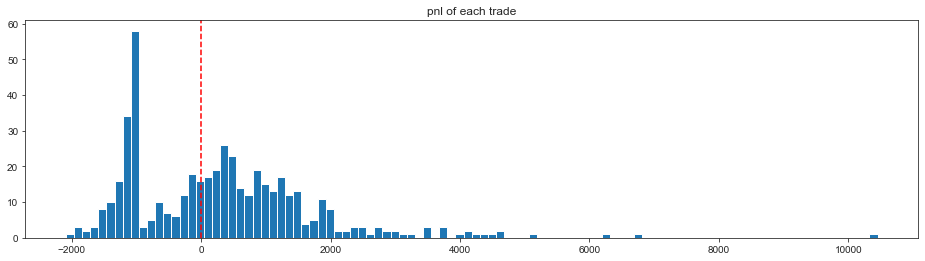

In [12]:
plt.figure(figsize=(16, 4))
plt.hist(df_history['pnl'], bins=100)
plt.axvline(0, ls='--', color='red')
plt.title('pnl of each trade')
plt.show()

Detailed trade history can be viewed as:

In [13]:
df_history = strategy.history.to_dataframe()
df_history

,trade_id,asset,lot,open_bar,close_bar,shut_bar,take,stop,pnl
order_id,,,,,,,,,
0,0,BRK-A,0.227273,2000-02-29,2000-05-29,2000-05-29,10000,-1000,3045.454545
1,1,JNJ,471.410836,2000-02-29,2000-05-29,2000-05-29,10000,-1000,2328.741011
2,2,PG,657.238593,2000-03-31,2000-06-30,2000-06-30,10000,-1000,93.625737
3,3,AMZN,149.253731,2000-03-31,2000-04-12,2000-06-30,10000,-1000,-1585.820896
4,4,MSFT,446.907793,2000-04-28,2000-05-25,2000-07-28,10000,-1000,-1182.797569
...,...,...,...,...,...,...,...,...,...
473,473,WMT,86.042128,2019-10-31,2019-12-31,2020-01-31,10000,-1000,180.201252
474,474,PG,82.413601,2019-11-29,2019-12-31,2020-02-29,10000,-1000,232.672297
475,475,XOM,148.885444,2019-11-29,2019-12-31,2020-02-29,10000,-1000,242.185337
